## Visualization with *yt* and Napari Part 2: annotations

In this notebook series, we'll continue our exploration of using [napari](https://napari.org/) to interactively visualize data loaded and sampled with [*yt*](yt-project.org/). The first notebook in this series [fixThislink](https://doesnoteexist.com) covered loading both in-memory and dask lazy-loaded *yt* arrays extracted from Fixed Resolution Regions into napari. In this notebook, we'll explore ways to use napari's point and shape layers to add annotations


## required packages

Running this notebook requires *yt* and napari in addition to stanard packages from the scipy stack (numpy, matplotlib). 


## imports 

So let's start off by setting up the `qt` environment needed by napari:

In [1]:
 # for napari, do it first!
%gui qt

and import all the packages we'll use

In [2]:
# general imports
import numpy as np
import matplotlib.pyplot as plt 
import os

# yt related
import yt
from yt.units import kpc, Mpc

# napari related imports 
import napari
from napari.utils import nbscreenshot

## Test data 

In this notebook, we'll use the `Enzo_64` test dataset (download [here](http://yt-project.org/data/Enzo_64.tar.gz), 2.4 Gb). So let's load and slice it, centered on the location of the max density:

yt : [INFO     ] 2020-09-04 15:10:08,541 Parameters: current_time              = 645.81707236914
yt : [INFO     ] 2020-09-04 15:10:08,541 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2020-09-04 15:10:08,541 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-09-04 15:10:08,542 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2020-09-04 15:10:08,542 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-09-04 15:10:08,543 Parameters: current_redshift          = 0.0013930880640796
yt : [INFO     ] 2020-09-04 15:10:08,543 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2020-09-04 15:10:08,543 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2020-09-04 15:10:08,544 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2020-09-04 15:10:08,544 Parameters: hubble_constant           = 0.71
Parsing Hierarchy : 100%|██████████| 752/752 [00:00<00:00, 8569.06it/s]
yt : [INFO     ] 2020-09-04 15:


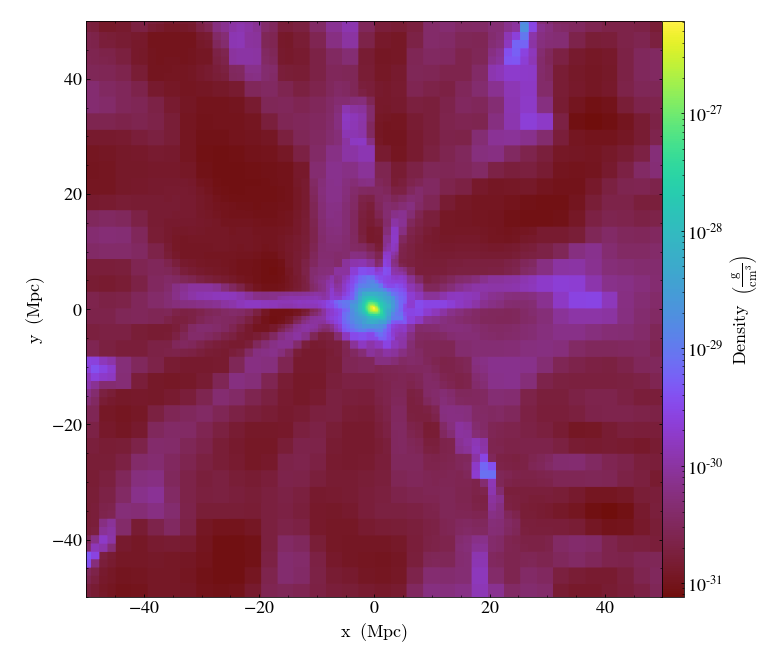

In [3]:
ds = yt.load("Enzo_64/DD0043/data0043")
slc = yt.SlicePlot(ds, 'z', 'density', center='m',width=(100,'Mpc'))
slc.show()

## Particle Position Annotations in Napari

In *yt*, we we can add particle positions to the slice following the example in the *yt* docs ([link](https://yt-project.org/doc/visualizing/callbacks.html#overplotting-particle-positions)):


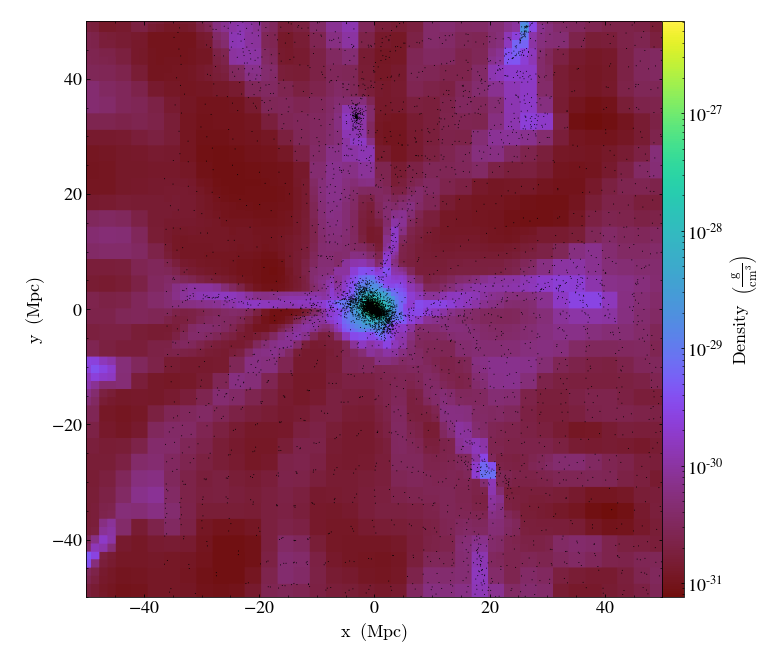

In [4]:
slc.annotate_particles((10, 'Mpc'))
slc.show()

But for napari, we'll need to extract that particle position data. 

Let's start, by following the previous notebook and pull out a Fixed Resolution Region of the log of the density field into memory and adding it to a napari viewer:

In [5]:
cg = ds.r[::300j,::300j,::300j]
dens_log = np.log10(cg['density'])

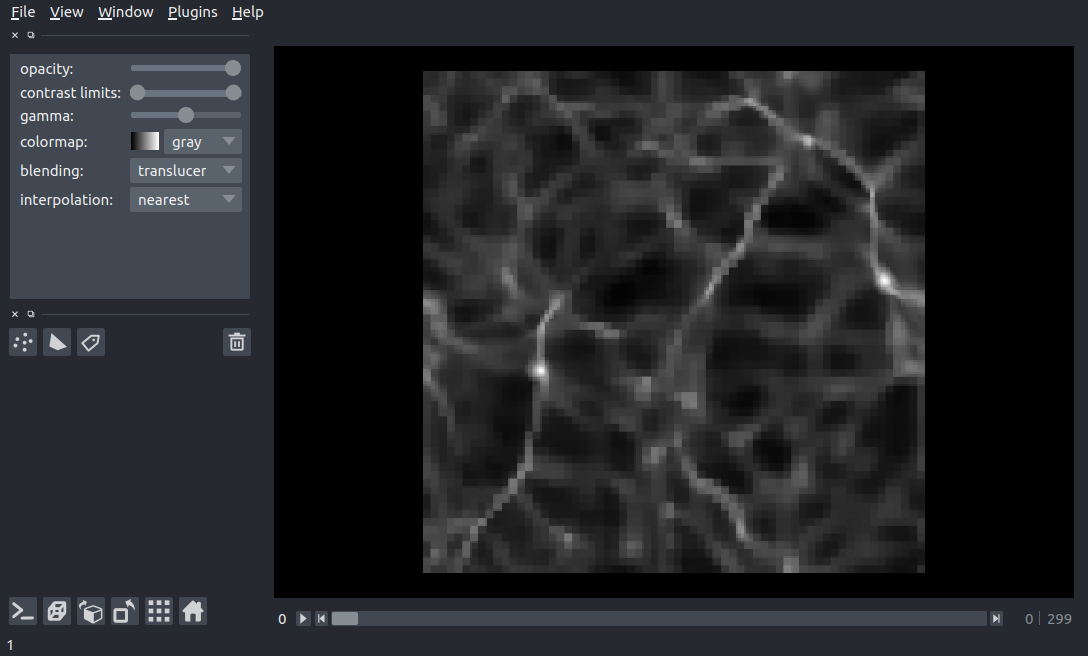

In [103]:
viewer = napari.Viewer()
viewer.add_image(dens_log)
nbscreenshot(viewer)

Now the question is how do we add our particle positions? 

From the napari docs, we have the following example ([link](https://napari.org/tutorials/fundamentals/points.html)) for adding points to an image:

```
from skimage import data
import napari

viewer = napari.view_image(data.astronaut(), rgb=True)
points = np.array([[100, 100], [200, 200], [300, 100]])
viewer.add_points(points, size=30)
```

where `points` is an array with shape `(N, D)` for `N` points in `D` dimensions. 

So all we need to do is extract some particle positions and reshape it to an array of the right dimensions. 

So let's do just that! Easy enough in *yt*: 

In [7]:
ad = ds.all_data()
particles = np.column_stack((ad['particle_position_x'],ad['particle_position_y'],ad['particle_position_z']))
particles.shape

(274305, 3)

Great! We now have our N by D array to add to napari! but wait... these positions are in the `code_length` of the data set:

In [8]:
ad['particle_position_x'][0]

unyt_quantity(0.01247314, 'code_length')

but our image's coordinate system is in pixel values so we need to convert our to a pixel coordinate system. Our domain in `code_length` goes from 0 to 1 in each dimension

In [9]:
print(ds.domain_left_edge)
print(ds.domain_right_edge)

[0. 0. 0.] code_length
[1. 1. 1.] code_length


and we pulled out a 300-pixel image, so we can just multiply the positions by 300: 

In [10]:
particles  = particles * 300 

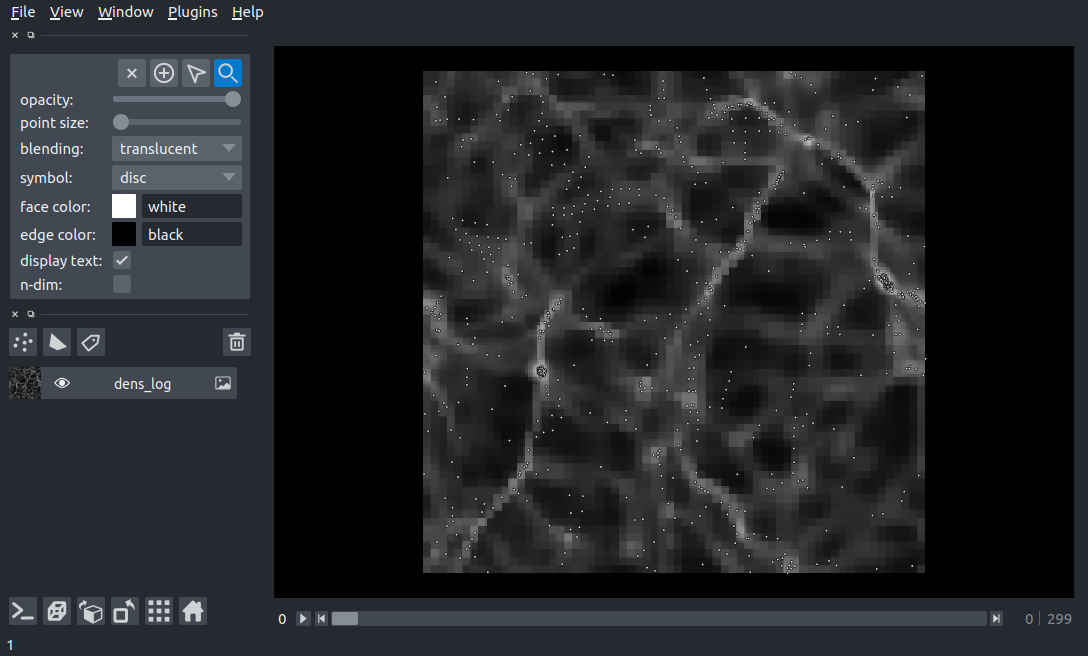

In [11]:
viewer.add_points(particles, size=1)
nbscreenshot(viewer)

Now when we slide through the domain, we also slice through the particle positions: 

<video controls src="resources/napari_5.mp4" />

## 3D Streamline Annotations in Napari

Napari also has a `path` shape type that we can use to add 3D streamlines. So let's first calculate some streamlines. Following [*yt*'s example streamline notebook](https://yt-project.org/doc/visualizing/streamlines.html), we first define our streamline starting positions as random position within a range of the domain center:

In [12]:
N = 30
c = ds.domain_center
scale = ds.domain_width[0]*.25
pos_dx = np.random.random((N,3))*scale - scale/2
pos = c+pos_dx

Now we create and integrate our streamline object (this step can take a few minutes):

In [14]:
# Create streamlines of the 3D vector velocity and integrate them through
# the box defined above
streamlines = yt.visualization.api.Streamlines(ds, pos, 'velocity_x', 'velocity_y', 'velocity_z',
                          length=30.0*Mpc, get_magnitude=True)
streamlines.integrate_through_volume()


yt : [INFO     ] 2020-09-04 14:53:04,936 AMRKDTree rebuilt, Final Volume: 1.000000e+00
Streamlining: 100%|██████████| 30/30 [00:00<00:00, 132.09it/s]


The `streamlines` object now has a list of streamlines in `streamlines.streamlines`. To access the first 5 positions of the the first streamline:

In [15]:
streamlines.streamlines[0][:5]

unyt_array([[0.42796054, 0.60897839, 0.39577305],
            [0.4271556 , 0.60887049, 0.39631162],
            [0.42634843, 0.60876346, 0.39684702],
            [0.42553901, 0.60865732, 0.39737918],
            [0.42472729, 0.60855205, 0.39790802]], 'code_length')

To add to napari, we can use the `viewer.add_shapes` with a `shape_type` of `line`, but first we once again need to convert to pixel coordinates

In [16]:
streamlines.streamlines = streamlines.streamlines * 300 

and then add to the viewer with: 

In [102]:
viewer.add_shapes(streamlines.streamlines, shape_type='path', edge_width=1, edge_color=['white'])
viewer.dims.ndisplay = 3
nbscreenshot(viewer)

NameError: name 'streamlines' is not defined

The streamlines won't be visible until we switch to a 3D view:
<video controls src="resources/napari_6.mp4" />

## annotating magnetic field vectors in napari

Napari also has a [vectors layer](https://napari.org/tutorials/fundamentals/vectors.html) so let's try adding some magnetic field vectors!

First, for reference we'll add an arbitrary single vector. `veiwer.add_vector()` expects a `vector` array as follows:

```
vectors : (N, 2, D) or (N1, N2, ..., ND, D) array
    An (N, 2, D) array is interpreted as "coordinate-like" data and a
    list of N vectors with start point and projections of the vector in
    D dimensions. An (N1, N2, ..., ND, D) array is interpreted as
    "image-like" data where there is a length D vector of the
    projections at each pixel.
```    

So a vectors array with a single vector starting at pixel `(1,1,1)`and ending at `(100,100,200)` would look like:

In [20]:
vectors = np.array([[
    [1,1,1],
    [100,100,200]    
]])

vectors.shape

(1, 2, 3)

In [19]:
viewer.add_vectors(
        vectors, edge_width=0.4, name='sliced vectors', edge_color='blue'
    )

<Vectors layer 'sliced vectors [2]' at 0x7f6c64fab090>

ds.field_list

In [99]:
step = 20
pos=np.arange(0,300,step)
posy,posz=np.meshgrid(pos,pos)

vectors = []
for i in range(0,300):
    posx = np.full(posy.shape,i)
    vx=cg['x-velocity'][i,0:300:step,0:300:step]
    vy=cg['y-velocity'][i,0:300:step,0:300:step]
    vz=cg['z-velocity'][i,0:300:step,0:300:step]
    
    v = np.column_stack((vx.ravel(),vy.ravel(),vz.ravel()))
    v_mag = np.linalg.norm(v,axis=1)       
    v_normed = v / v_mag[:,None]
    
    p = np.column_stack((posx.ravel(),posy.ravel(),posz.ravel()))
    
    vectors.extend(np.array([[pv[0],pv[1]] for pv in zip(p,v_normed)]))
    
vectors = np.array(vectors)
    
    

In [100]:
vectors.shape

(67500, 2, 3)

In [104]:
viewer.add_vectors(
        vectors, edge_width=0.5, name='sliced vectors', edge_color='white'
    )

<Vectors layer 'sliced vectors' at 0x7f6c2b9b3a50>

In [105]:
viewer.add_image(cg['velocity_x'])
viewer.add_image(cg['velocity_y'])
viewer.add_image(cg['velocity_z'])

<Image layer 'Image [2]' at 0x7f6c64e05b50>